<a href="https://colab.research.google.com/github/ingenum-ai/isvee_ML_for_epidemiology_course/blob/main/ISVEE_Day4_Session3_ModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MarkdownContent_Header.png

#Session 3 - PyTorch

##Building a 'simple' neural network






Machine learning and deep learning take data from the past, build an algorithm (like a neural network) to discover patterns and then use these patterns to predict the future.


&nbsp;

*Simple enough, heh...?!*

&nbsp;

In this exercise we are going to build a simple nueral network using the 'Feedlot' dataset that we have been working with earlier in the course.

We are going to do this using Python and the PyTorch library

The script is laid out in Markdown text and code chunks in this notebook below. Work through each of these sections before attempting the questions. We will build our model before lunch and then fit and evaluate it after lunch.

&nbsp;



## Model building workflow

In this module we're going to cover a typical PyTorch workflow.

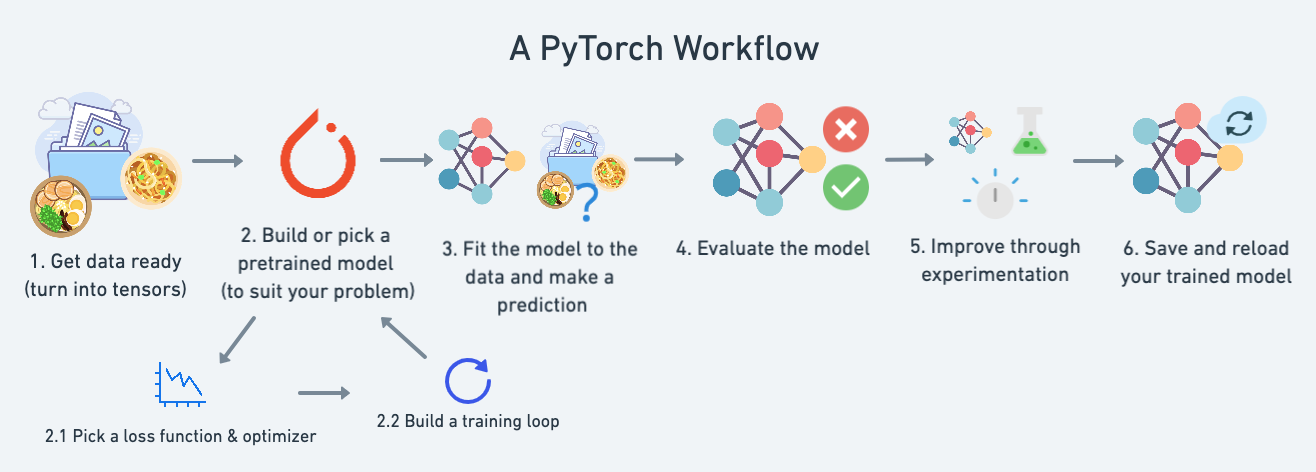


For now, we'll use this workflow to predict a a dichotmous outcome (bulling) using a single categorical input (treatment_protocol) but the workflow steps is repeatable and pretty applicable to almost all circumstances.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to import the Feedlot dataset |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. |
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, so finally, we'll cover that too. |



## Where can I get help?

Ask a course coordinators, of course, but before you do so, try to look back through the notes and preceding steps and/or use Google's Gemini AI that accompanies each notebook. It is a useful resource but does not know everything!

All of the materials and data for this course are [available on GitHub](https://github.com/ingenum-ai/isvee_ML_for_epidemiology_course).

There is extra reading and useful links included at the end of each notebook

There's also the [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch.




##Let's import what we'll need for this module.

Just like R, we'll import the libraries we need first up here. It is tidier and avoids confusion later.

We're going to chiefly use [PyTorch](https://pytorch.org/) `torch` with a little help from [scikit-learn](https://scikit-learn.org/stable/) `sklearn`.

`torch.nn` (`nn` stands for neural network and this package contains the building blocks for creating neural networks in PyTorch).

We will also use `pandas` and `matplotlib` libraries. `pandas` is a Python library that helps us use dataframes and `matplotlib` helps plotting a ddisplaying our data




In [1]:
# Import libraries for exercise

# pytorch
#!pip install torch
import torch
from torch import nn                      # nn contains all of PyTorch's building blocks for neural networks
from torch import Tensor                  # tensor node in the computation graph

import torch.autograd as autograd         # computation graph
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

#scikit
#!pip install scikit-learn==1.3.0
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


import pandas as pd
import matplotlib.pyplot as plt


# Check PyTorch version
torch.__version__

'2.5.0+cu121'

## 1. Data (preparing and loading)

We are using numerical epidemiological data because, honestly, that is what we are used to but data machine learning can use anything that can be converted to numbers: images of any kind, videos, audio files, protein structures, text and more. We won't have a chance to play with these all today but I have included some links to some online resources that can take you through these processes. In each case, everything comes down to numbers!


Machine learning is a game of two parts:
1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.





###Model data

In the ISVEE Day 4 Github repository there is a dataset that contains a subset of the feedlot data set


To save time, we have selected a limited number of feilds from the original datset and red it into a python notebook (Colab) datafile. You can see the code used to do this [here](https://github.com/ingenum-ai/isvee_ML_for_epidemiology_course/blob/main/Copy_of_ISVEE_Read_Compile_FeedlotData.ipynb)

Run the next chunk of code to mount your google drive and import the data. The head function shows you the top five lines, much as R does.

You will see that we are only going to use five selcted columns from the original data.


In [2]:
# Mount your own Google Drive with raw dta from Github repository

from google.colab import drive
drive.mount('/content/drive')

# Import feedlot_raw.csv

df1 = pd.read_csv('/content/drive/Shareddrives/ingenum_operations/5_Current_Projects/23_07_ISVEE_PreConf_workshop/3_Data/feedlot_raw.csv',  encoding='latin-1')
df1.head()


Mounted at /content/drive


,buller2,ind_weight,ind_month,ind_season,treatment_protocol
0,0,406,2021-01,Summer,Control
1,0,440,2021-01,Summer,AB11
2,0,363,2021-01,Summer,AB11
3,1,359,2021-01,Summer,ANA10
4,1,393,2021-01,Summer,AB11


### Split data into training and test sets

Great, we've got some data.

Before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

For now, we'll just use a training and test set, this means we'll have one dataset for our model to learn on as well as one to be evaluated on. It is best to keep these both seperated right at the beginning.



 We want our model to learn from training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.


For categorical data we want each dataset to be representative of each input variable (i.e.  `treatment_protocol` in this case) so we will first stratify the raw data to accomplish this.

For this we shall use a useful module from the scikit library, principaly the `OneHotEncoder` function from the `sklearn.preprocessing` module.

> `OneHotEncoder` converts categorical data into a format that can be used in machine learning models. Instead of encoding categories with integers (which can imply an unwanted ordinal relationship), OneHotEncoder creates a binary (0 or 1) column for each category. For instance, if a dataset includes a column for “Color” with values “Red,” “Blue,” and “Green,” OneHotEncoder will create three new binary columns, one for each color, marking a “1” in the respective column if the color matches and “0” otherwise. This approach prevents the model from interpreting any ordinal relationship among the categories, which is critical for many algorithms to perform correctly.

In [3]:
# Stratify raw dataset

encoder = OneHotEncoder(sparse_output=False)

feature_set = df1['treatment_protocol'].values.reshape(-1, 1)
feature_set_encoded = encoder.fit_transform(feature_set)

target = df1['buller2'].values


OK, now we're ready to split our data into 80% training and 20% test data.

In [4]:
# Split raw dataset

dataset_split = train_test_split(*[feature_set_encoded, target],
                                 test_size=0.2,
                                 stratify=target,
                                 random_state=42)

Lets take a look at at the shape and the class balance of our two feature datasets (`y_train` and `y_test`)...

In [5]:
# Print the shape files

for i in dataset_split:
  print(i.shape) # X_train, X_test, y_train, y_test

# Create a library fo these datasets

data = {k:v for k, v in zip(['X_train', 'X_test', 'y_train', 'y_test'], dataset_split)}

# Check class balance of features

print(data['y_train'].sum()/len(data['y_train']))
print(data['y_test'].sum()/len(data['y_test']))

(120064, 11)
(30017, 11)
(120064,)
(30017,)
0.09248400852878465
0.09248092747443115


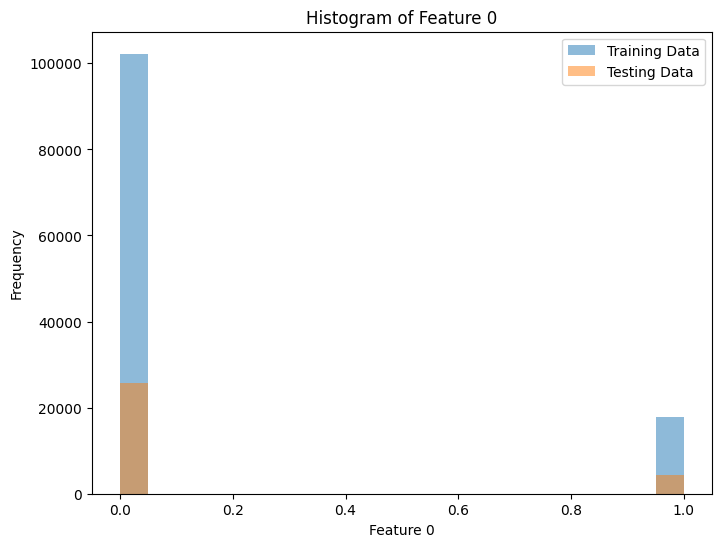

In [6]:
# Plot a histogram of these data

X_train, X_test, y_train, y_test = dataset_split

# Choose a feature to plot (e.g., feature 0)
feature_index = 0

plt.figure(figsize=(8, 6))
plt.hist(X_train[:, feature_index], bins=20, alpha=0.5, label="Training Data")
plt.hist(X_test[:, feature_index], bins=20, alpha=0.5, label="Testing Data")
plt.xlabel(f"Feature {feature_index}")
plt.ylabel("Frequency")
plt.title(f"Histogram of Feature {feature_index}")
plt.legend()
plt.show()

Great. This looks good heh!

Now we have a training dataset (`X`) and a feature set (`y`). The numbers approximate an 80:20 spolit and the representation of `treatment_protocols` is almost identical between the datasets.

To keep things tidy, we have also created a 'dictionary' of these datasets called `data` so that we can call them easily. In Python, `{ ... }` create a dictionary comprehension, which is a concise way to create a new dictionary.


###Convert these data to tensors

Now, lets do what we were practicing in Session 2 and convert these dataframes to tensors.



In [7]:
# Convert to tensors

tensors = {k:torch.tensor(v, dtype=torch.long) for k,v in data.items()}

X_train = tensors['X_train'].type(torch.float32)
X_test = tensors['X_test'].type(torch.float32)
y_train = tensors['y_train'].type(torch.float32)
y_test = tensors['y_test'].type(torch.float32)



Well done! This is a big step.

We have called the PyTorch `torch.tensor` function which is where the magic happens. It takes the value (v) and converts it into a PyTorch tensor using the `torch.tensor()` function.

It's like saying, "Give me all the keys and their corresponding values from the dictionary."

`for k, v in...` is a loop that goes through each key-value pair. k represents the key, and v represents the value.

`dtype=torch.long` specifies that the tensor should have an integer data type.

`k: ...: This assigns the newly created tensor to the key (`k`) in the tensors dictionary.



Take a look at the tensors by simply calling the `tensor` dictionary

Count the square brackets and familiarise yourself with the shape of each tensor.

In [8]:
# call the tensor dictinary

tensors

{'X_train': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [1, 0, 0,  ..., 0, 0, 0]]),
 'X_test': tensor([[0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]]),
 'y_train': tensor([1, 0, 0,  ..., 0, 0, 0]),
 'y_test': tensor([0, 0, 0,  ..., 0, 0, 0])}

Beautiful! Now we're going to move towards building a model that can learn the relationship between `X` (**features**) and `y` (**labels**).

Wonderful, we've got samples for training (`X_train` & `y_train`) and samples for testing (`X_test` & `y_test`).

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.



## 2. Build model

Now we've got some data, let's build a model to use the treatment protocol to predict the odds of an animal bulling.

We'll write the code first and then explain everything.

> **Resource:** We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, I'd recommend reading [Real Python's Object Orientating programming in Python 3 guide](https://realpython.com/python3-object-oriented-programming/) a few times.

Let's replicate a standard logistic regression model using pure PyTorch.

In [9]:
# Create a logisitic regression model class using the trinaing data

class LogisticRegressionModel(nn.Module):       # almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)  # input_size is the number of features in X_train


# Forward defines the computation in the model
    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Apply sigmoid function for logistic regression



###What have we just done?
Alright there's a fair bit going on above but let's break it down bit by bit.



We have created a class LogisticRegressionModel that inherits from nn.Module, which is the base class for all neural network modules in PyTorch.

We then initialised the model using `__init__`

This is the constructor of the class. `super().__init__()` calls the constructor of the parent class (nn.Module).

`self.linear = nn.Linear(input_size, 1)` creates a linear layer that takes input_size features as input and produces a single output. Input_size should be the number of features in your X_train data (in our case, 11).


`forward(self, x)` defines how the input data (x) flows through the model.

`torch.sigmoid(self.linear(x))` Passes the input (x) through the linear layer (self.linear(x)), and then the sigmoid function (torch.sigmoid) is applied to the output to get probabilities between 0 and 1, a characteristic of logistic regression.

The linear regression below is not relevant any longer (skip this step)

In [10]:
# Create a Logisitc Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)

      return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

## PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data.



![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module` for a LINEAR regression model taken from material produced by @mrdbourke.*

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).



##Inspecting the Structure of our Logistic Regression Model

Now that we've set up the foundation, let's instantiate our logistic regression model and examine its internal components using the `.parameters()` method.

This allows us to understand how the model is structured and access its learnable parameters.

In [18]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Assuming your input size is, for example, 11:
input_size = tensors['X_train'].shape[1]  # Get input size from your training data

# Create an instance (instantiate) of the model, providing the input_size
model_0 = LogisticRegressionModel(input_size)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

# Print the model's parameters
print("Model Parameters:")
for name, param in model_0.named_parameters():
    print(f"  {name}: {param.shape}")


Model Parameters:
  linear.weight: torch.Size([1, 11])
  linear.bias: torch.Size([1])


We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [13]:
# List named parameters
model_0.state_dict()


OrderedDict([('linear.weight',
              tensor([[ 0.2305,  0.2503, -0.0706,  0.2770, -0.0661,  0.0608, -0.1468,  0.1771,
                        0.2658, -0.2212,  0.2621]])),
             ('linear.bias', tensor([0.0564]))])

Notice how the values for `weights` and `bias` from `model_0.state_dict()` come out as random float tensors?

While you can technically set the weights and bias directly using nn.Parameter as the slide demonstrates, it's generally not the recommended way when using nn.Linear. Here's why:

- **nn.Linear Already Handles It.** The nn.Linear layer already creates and manages its own weight and bias parameters internally. When you initialize nn.Linear(input_size, 1), it automatically creates the necessary weight and bias tensors with random initialization.

- **Potential Conflicts.** Manually setting weights and bias potentially conflicts with how nn.Linear handles its parameters.

Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best (the hardcoded `weight` and `bias` values we set when creating our straight line data).

> **Exercise:** Try changing the `torch.manual_seed()` value two cells above, see what happens to the weights and bias values.

Because our model starts with random values, right now it'll have poor predictive power.



### Making predictions using `torch.inference_mode()`
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

Let's make some predictions.

In [14]:




# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)



Hmm?

You probably noticed we used [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

> **Note:** In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things,
`torch.inference_mode()` is newer, potentially faster and preferred. See this [Tweet from PyTorch](https://twitter.com/PyTorch/status/1437838231505096708?s=20) for more.

We've made some predictions, let's see what they look like.

In [15]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 30017
Number of predictions made: 30017
Predicted values:
tensor([[0.5799],
        [0.5293],
        [0.5712],
        ...,
        [0.5799],
        [0.5799],
        [0.5799]])


Notice how there's one prediction value per testing sample.

This is because of the kind of data we're using. For our straight line, one `X` value maps to one `y` value.

However, machine learning models are very flexible. You could have 100 `X` values mapping to one, two, three or 10 `y` values. It all depends on what you're working on.

Our predictions are still numbers on a page, let's visualize them with our `plot_predictions()` function we created above.

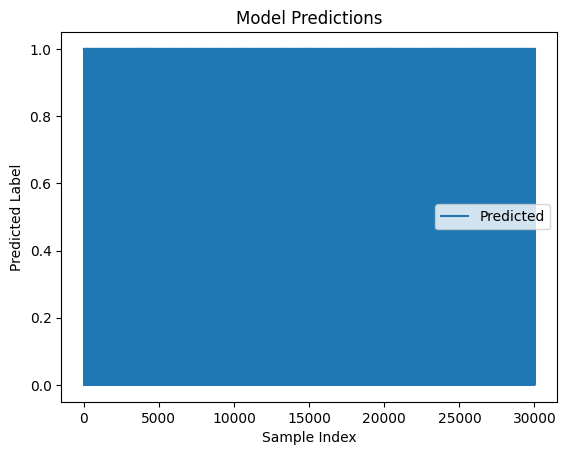

In [ ]:
plot_predictions(predictions=y_preds)

In [16]:
y_test - y_preds

tensor([[-0.5799, -0.5799, -0.5799,  ..., -0.5799, -0.5799, -0.5799],
        [-0.5293, -0.5293, -0.5293,  ..., -0.5293, -0.5293, -0.5293],
        [-0.5712, -0.5712, -0.5712,  ..., -0.5712, -0.5712, -0.5712],
        ...,
        [-0.5799, -0.5799, -0.5799,  ..., -0.5799, -0.5799, -0.5799],
        [-0.5799, -0.5799, -0.5799,  ..., -0.5799, -0.5799, -0.5799],
        [-0.5799, -0.5799, -0.5799,  ..., -0.5799, -0.5799, -0.5799]])

Woah! Those predictions look pretty bad...

This makes sense though, when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

Time to change that.

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.



### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are:

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).

Woah, that's a lot, let's see it in code.

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

To create these we're going to write a Python `for` loop in the theme of the [unofficial PyTorch optimization loop song](https://twitter.com/mrdbourke/status/1450977868406673410?s=20) (there's a [video version too](https://youtu.be/Nutpusq_AFw)).

![the unofficial pytorch optimization loop song](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-optimization-loop-song.png)
*The unofficial PyTorch optimization loops song, a fun way to remember the steps in a PyTorch training (and testing) loop.*

There will be a fair bit of code but nothing we can't handle.




### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* computing the gradients of the loss with respect to every model parameter (`loss.backward()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

For resources to help understand what's happening behind the scenes with backpropagation and gradient descent, see the extra-curriculum section.



### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

NameError: name 'torch' is not defined

Oh would you look at that! Looks like our loss is going down with every epoch, let's plot it to find out.

In [ ]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

NameError: name 'epoch_count' is not defined

<Figure size 1000x700 with 0 Axes>

Nice! The **loss curves** show the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (`weights` and `bias`) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) to see how close our model gets to the original values we set for weights and bias.



In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Wow! How cool is that?

Our model got very close to calculating the exact original values for `weight` and `bias` (and it would probably get even closer if we trained it for longer).

> **Exercise:** Try changing the `epochs` value above to 200, what happens to the loss curves and the weights and bias parameter values of the model?

It'd likely never guess them *perfectly* (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically**.

## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

Nice! We've made some predictions with our trained model, now how do they look?

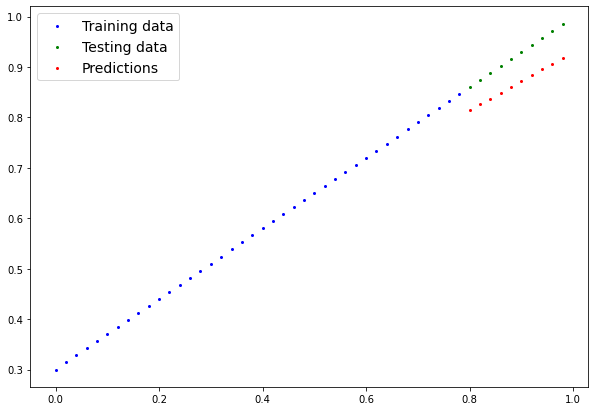

In [ ]:
plot_predictions(predictions=y_preds)

Woohoo! Those red dots are looking far closer than they were before!

Let's get onto saving and reloading a model in PyTorch.

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? |
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  |
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. |

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


### Saving a PyTorch model's `state_dict()`

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 daniel daniel 1063 Nov 10 16:07 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by creating another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol>
</details>



In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Nice!

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.

> **Note:** There are more methods to save and load PyTorch models but I'll leave these for extra-curriculum and further reading. See the [PyTorch guide for saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) for more.

## Exercises

All exercises have been inspired from code throughout the notebook.

There is one exercise per major section.

You should be able to complete them by referencing their specific section.

> **Note:** For all exercises, your code should be device agnostic (meaning it could run on CPU or GPU if it's available).

1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.
2. Build a PyTorch model by subclassing `nn.Module`.
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.
3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.
4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).
5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

> **Resource:** See the [exercises notebooks templates](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/exercises) and [solutions](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) on the course GitHub.

## Extra-curriculum

* Read [What is `torch.nn`, really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works.
* Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) for all of the different PyTorch modules you might come across.
* Spend 10-minutes reading the [loading and saving documentation on the PyTorch website](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to become more familiar with the different saving and loading options in PyTorch.
* Spend 1-2 hours reading/watching the following for an overview of the internals of gradient descent and backpropagation, the two main algorithms that have been working in the background to help our model learn.
 * [Wikipedia page for gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
 * [Gradient Descent Algorithm — a deep dive](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21) by Robert Kwiatkowski
 * [Gradient descent, how neural networks learn video](https://youtu.be/IHZwWFHWa-w) by 3Blue1Brown
 * [What is backpropagation really doing?](https://youtu.be/Ilg3gGewQ5U) video by 3Blue1Brown
 * [Backpropagation Wikipedia Page](https://en.wikipedia.org/wiki/Backpropagation)
